In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
from scipy import stats
import chaospy as cp

import matplotlib.pyplot as plt

In [2]:
R = 40.
H = 60
x_w = -40#30.
y_w = 60#90.
Rw = 40#20
seed = 3

def f(x,y,seed):
    np.random.seed(seed)
    return - 3.*np.exp( -((x-x_w)**2. + (y-y_w)**2.)/(Rw**2.) ) + \
           - 3.*np.exp( -((x-30)**2. + (y-40)**2.)/(20**2.) ) + \
           - 1.5*np.exp( -((x-np.random.uniform(-60,60))**2. + (y-np.random.uniform(40,70))**2.)/(60.**2.) ) #+ 4.*(y/H)**0.0 
    
def f1(x,y):
    return - 3.*np.exp( -((x-x_w)**2. + (y-y_w)**2.)/(Rw**2.) )

def f3(x,y):
    return - 3.*np.exp( -((x-30)**2. + (y-40)**2.)/(20**2.) )
    
def f2(x,y,seed):
    np.random.seed(seed)
    return - 1.5*np.exp( -((x-np.random.uniform(-60,60))**2. + (y-np.random.uniform(40,70))**2.)/(60.**2.) ) #+ 4.*(y/H)**0.0     

In [3]:
x_mesh,y_mesh = np.meshgrid(np.arange(-50.,100.,0.1),np.arange(0.,120.,0.1))

F = f(x_mesh,y_mesh,seed)

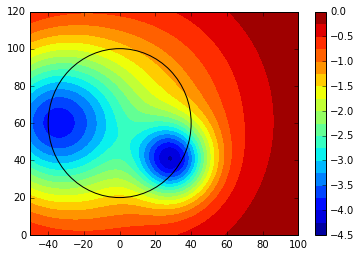

In [4]:
plt.contourf(x_mesh,y_mesh,F,20)
cb = plt.colorbar()
circ = plt.Circle([0.,H],R,ec='k',fill=False)
ax = plt.gca()
ax.add_patch(circ)
print

## Monte-Carlo integration

In [5]:
def MC_int(f,seed):
    x_MC = np.random.uniform(-R,R,int(9e6))
    y_MC = np.random.uniform(-R,R,int(9e6)) + H

    r = np.sqrt(x_MC**2. + (y_MC-H)**2.)
    ind_in = np.where(r <= R)

    u_eq_MC = np.mean(f(x_MC[ind_in],y_MC[ind_in],seed))
    return u_eq_MC, x_MC[ind_in], y_MC[ind_in]

In [6]:
u_eq_MC, x_MC, y_MC = MC_int(f,seed)

7067113


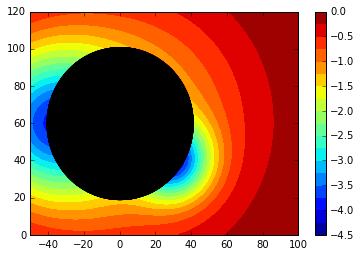

In [7]:
plt.contourf(x_mesh,y_mesh,F,20)
cb = plt.colorbar()
circ = plt.Circle([0.,H],R,ec='k',fill=False)
ax = plt.gca()
ax.add_patch(circ)
plt.plot(x_MC,y_MC,'.k',alpha=0.05)
x_plot = np.arange(-50.,50.1,0.1)
print len(x_MC)

## Quasi Monte-Carlo integration Antithetic: Minimum variance in the estimator

In [8]:
def QMC_int(f,seed):
    dist_y = cp.Uniform(-R,R)
    dist_x = cp.Uniform(-(R**2.-dist_y**2.)**0.5,(R**2.-dist_y**2.)**0.5)#cp.Uniform(-R,R)#
    dist = cp.J(dist_y,dist_x)

    sample = dist.sample(size=16,rule='M',antithetic=[1])
    y_MC = sample[0,:]+H
    x_MC = sample[1,:]

    r = np.sqrt(x_MC**2. + (y_MC-H)**2.)
    ind_in = np.where(r <= R)
        
    u_eq_QMC = np.mean(f(x_MC[ind_in],y_MC[ind_in],seed))
    
    return u_eq_QMC, x_MC[ind_in], y_MC[ind_in]

In [9]:
u_eq_QMC, x_MC, y_MC = QMC_int(f,seed)

print u_eq_QMC
print 100*(u_eq_QMC-u_eq_MC)/u_eq_MC, '%'

-2.75753651825
4.4721638393 %


16


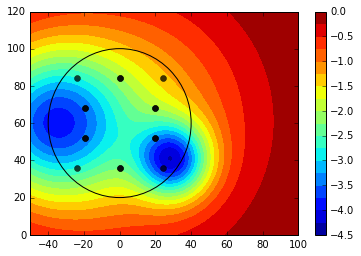

In [10]:
plt.contourf(x_mesh,y_mesh,F,20)
cb = plt.colorbar()
circ = plt.Circle([0.,H],R,ec='k',fill=False)
ax = plt.gca()
ax.add_patch(circ)
plt.plot(x_MC,y_MC,'ok',alpha=0.75)
x_plot = np.arange(-50.,50.1,0.1)
print len(x_MC)

## Quasi Monte-Carlo integration Hammersley in the Polar distribution

In [11]:
def QMC_int2(f,seed):
    dist_r = cp.Triangle(0,R,R)
    dist_th = cp.Uniform(0,360)
    dist = cp.J(dist_r,dist_th)
    dist_U = cp.J(cp.Uniform(),cp.Uniform())
    
    sample = dist.sample(size=16,rule='H')
    r  = sample[0,:]
    th = sample[1,:]+90

    x_MC = r*np.cos(np.deg2rad(th))
    y_MC = r*np.sin(np.deg2rad(th))+H

    ind_in = np.where(r <= R)
    
    u_eq_QMC = np.mean(f(x_MC[ind_in],y_MC[ind_in],seed))
    
    return u_eq_QMC, x_MC[ind_in], y_MC[ind_in]

In [12]:
u_eq_QMC2, x_MC, y_MC = QMC_int2(f,seed)

print u_eq_QMC2
print 100*(u_eq_QMC2-u_eq_MC)/u_eq_MC, '%'

-2.57889662367
-2.29579597266 %


16


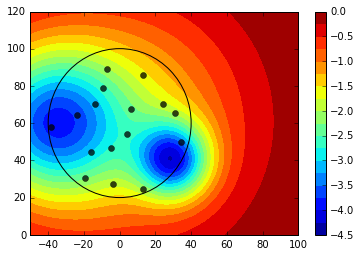

In [13]:
plt.contourf(x_mesh,y_mesh,F,20)
cb = plt.colorbar()
circ = plt.Circle([0.,H],R,ec='k',fill=False)
ax = plt.gca()
ax.add_patch(circ)
plt.plot(x_MC,y_MC,'ok',alpha=0.75)
x_plot = np.arange(-50.,50.1,0.1)
print len(x_MC)

## Integration using Rossenblatt transformation and Gaussian quadrature Cartessian coord

In [14]:
def PCE_int_cart(f,seed):
    dist_x = cp.Uniform(-40,40)
    dist_y = cp.Uniform(-(R**2.-dist_x**2.)**0.5+H,(R**2.-dist_x**2.)**0.5+H)
    dist = cp.J(dist_x,dist_y)
    dist_U = cp.J(cp.Uniform(),cp.Uniform())
    
    M = 3
    P = cp.orth_ttr(M,dist_U)
    nodes_U, weights = cp.generate_quadrature(M, dist_U, rule='G')#,sparse=True)
    nodes = dist.inv(dist_U.fwd(nodes_U)) 

    x_MC = nodes[0,:]
    y_MC = nodes[1,:]
    
    sample_u_train = f(x_MC,y_MC,seed)
    u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train)
    u_eq_PCE = cp.E(u_hat,dist_U)
   
    return u_eq_PCE, x_MC, y_MC, weights

In [15]:
u_eq_PCE_cart, x_MC, y_MC, weights = PCE_int_cart(f,seed)

print u_eq_PCE_cart
print 100*(u_eq_PCE_cart-u_eq_MC)/u_eq_MC, '%'

-2.70698977105
2.55714729464 %


16


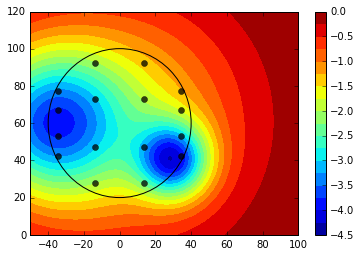

In [16]:
plt.contourf(x_mesh,y_mesh,F,20)
cb = plt.colorbar()
circ = plt.Circle([0.,H],R,ec='k',fill=False)
ax = plt.gca()
ax.add_patch(circ)
plt.plot(x_MC,y_MC,'ok',alpha=0.75)

print len(x_MC)

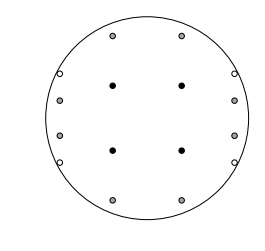

In [17]:
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.scatter(x_MC/R,y_MC/R-H/R,s=30,c=weights,cmap=plt.cm.gray_r)
circ = plt.Circle([0.,0.],1.,ec='k',fill=False)
ax.add_patch(circ)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_axis_off()

## Integration using Rossenblatt transformation and Gaussian quadrature Polar

```python
r_lns=np.linspace(0,R,100)
plt.plot(r_lns,cp.Triangle(0,R,R).pdf(r_lns))
#```

In [23]:
def PCE_int(f,seed):
    dist_r = cp.Triangle(0,R,R)
    dist_th = cp.Uniform(0,360)
    dist = cp.J(dist_r,dist_th)
    dist_U = cp.J(cp.Uniform(),cp.Uniform())
    
    M = 3
    P = cp.orth_ttr(M,dist_U)
    nodes_U, weights = cp.generate_quadrature([3,M], dist_U, rule='G')
    nodes = dist.inv(dist_U.fwd(nodes_U)) 
    #nodes, weights = cp.generate_quadrature([3,M], dist, rule='G') 

    r = nodes[0,:]
    th = nodes[1,:]-90
    x_MC = r*np.cos(np.deg2rad(th))
    y_MC = r*np.sin(np.deg2rad(th))+H

    sample_u_train = f(x_MC,y_MC,seed)
    u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train)
    
    u_eq_PCE = cp.E(u_hat,dist_U)
   
    return u_eq_PCE, x_MC, y_MC, nodes, weights    

In [24]:
u_eq_PCE, x_MC, y_MC, nodes, weights = PCE_int(f,seed)

print u_eq_PCE
print 100*(u_eq_PCE-u_eq_MC)/u_eq_MC, '%'

-2.51415570718
-4.74857351157 %


16


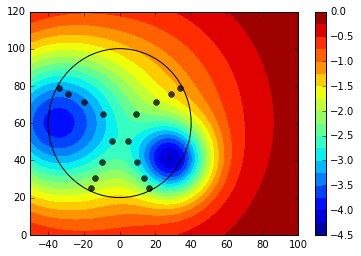

In [25]:
plt.contourf(x_mesh,y_mesh,F,20)
cb = plt.colorbar()
circ = plt.Circle([0.,H],R,ec='k',fill=False)
ax = plt.gca()
ax.add_patch(circ)
plt.plot(x_MC,y_MC,'ok',alpha=0.75)
print len(x_MC)

In [26]:
for i in range(len(weights)):
    print '[', '{0:0.20f}'.format(nodes[0,i]/R), ', ', '{0:0.20f}'.format(np.mod(np.deg2rad(nodes[1,i]-90.),2.*np.pi)),  ', ', '{0:0.20f}'.format(weights[i]), '], '
print    

for i in range(len(weights)):
    print '      r_node('+str(i+1)+') =', '{0:0.20f}'.format(nodes[0,i]/R)
    print '      th_node('+str(i+1)+') =', '{0:0.20f}'.format(np.mod(np.deg2rad(nodes[1,i]-90.),2.*np.pi))
    print '      weight('+str(i+1)+') =', '{0:0.20f}'.format(weights[i])
    print

#print nodes[0,:]/R
#print nodes[1,:]
#print weights

[ 0.26349922998554242692 ,  5.14864212373119656263 ,  0.03025074832140048006 ], 
[ 0.26349922998554242692 ,  0.50271437790892070652 ,  0.05671296296296297890 ], 
[ 0.26349922998554242692 ,  2.63887827568087196539 ,  0.05671296296296290951 ], 
[ 0.26349922998554242692 ,  4.27613583703818367354 ,  0.03025074832140050435 ], 
[ 0.57446451431535072718 ,  5.14864212373119656263 ,  0.05671296296296297890 ], 
[ 0.57446451431535072718 ,  0.50271437790892070652 ,  0.10632332575267369745 ], 
[ 0.57446451431535072718 ,  2.63887827568087196539 ,  0.10632332575267357255 ], 
[ 0.57446451431535072718 ,  4.27613583703818367354 ,  0.05671296296296302053 ], 
[ 0.81852948743000586429 ,  5.14864212373119656263 ,  0.05671296296296290951 ], 
[ 0.81852948743000586429 ,  0.50271437790892070652 ,  0.10632332575267357255 ], 
[ 0.81852948743000586429 ,  2.63887827568087196539 ,  0.10632332575267344765 ], 
[ 0.81852948743000586429 ,  4.27613583703818367354 ,  0.05671296296296295808 ], 
[ 0.96465960618086743494 ,  

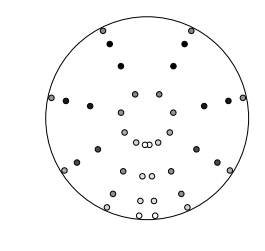

In [22]:
r_aux = nodes[0,:]/R
th_aux = np.mod(np.deg2rad(nodes[1,:]-90.),2.*np.pi)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.scatter(r_aux*np.cos(th_aux),r_aux*np.sin(th_aux),s=30,c=weights,cmap=plt.cm.gray_r)
circ = plt.Circle([0.,0.],1.,ec='k',fill=False)
ax.add_patch(circ)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_axis_off()
fig.savefig('PCE_Quad_rotor.pdf')

### sum of quadratures is equal to the quadrature of the sum

In [23]:
dist_r = cp.Triangle(0,R,R)
dist_th = cp.Uniform(0,360)
dist = cp.J(dist_r,dist_th)
dist_U = cp.J(cp.Uniform(),cp.Uniform())

M = 4
P = cp.orth_ttr(M,dist_U)
nodes_U, weights = cp.generate_quadrature([3,M], dist_U, rule='G')
nodes = dist.inv(dist_U.fwd(nodes_U)) 

r = nodes[0,:]
th = nodes[1,:]-90
x_MC = r*np.cos(np.deg2rad(th))
y_MC = r*np.sin(np.deg2rad(th))+H

sample_u_train_1 = f1(x_MC,y_MC)
u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train_1)
u_eq_PCE_1 = cp.E(u_hat,dist_U)

sample_u_train_2 = f2(x_MC,y_MC,seed)
u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train_2)
u_eq_PCE_2 = cp.E(u_hat,dist_U)

sample_u_train_3 = f3(x_MC,y_MC)
u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train_3)
u_eq_PCE_3 = cp.E(u_hat,dist_U)

sample_u_train = f(x_MC,y_MC,seed)
u_hat = cp.fit_quadrature(P, nodes, weights, sample_u_train)
u_eq_PCE = cp.E(u_hat,dist_U)

In [24]:
u_eq_PCE_sum = u_eq_PCE_1 + u_eq_PCE_2 + u_eq_PCE_3

print u_eq_PCE, '   \t', u_eq_PCE_sum
print 100*(u_eq_PCE-u_eq_MC)/u_eq_MC, '%', '\t', 100*(u_eq_PCE_sum-u_eq_MC)/u_eq_MC, '%'

-2.63420966108    	-2.63420966108
-0.200203523182 % 	-0.200203523182 %


## Larsen's Gaussian quadrature. Current implementation in FusedWake

In [25]:
def gaussN(R, func, varargin, NGr=4, NGth=4):
    """Calculate numerically the gauss integration.
    [1] eq. 38

    Inputs
    ----------
    R (float): Wind turbine radius [m]
    func (function): Wind speed function
    varargin: Other arguments for the function besides [r,te]
    NG (int): Number of Ga

    Outputs
    ----------
    Ua (float):
    """
    A = np.pi*R**2
    #coefficients
    if  (NGr==4)&(NGth==4): #for speed give the full values
        rt = np.array([[ -0.339981043584856, -0.861136311594053,
            0.339981043584856, 0.861136311594053]])
        te = rt.T
        w = np.array([[0.652145154862546, 0.347854845137454,
            0.652145154862546, 0.347854845137454]])
        wt=w
    else:
        rt,w = np.polynomial.legendre.leggauss(NGr)
        rt = np.array([rt])
        #te = rt.T
        w = np.array([w])
        te,wt = np.polynomial.legendre.leggauss(NGr)
        te = np.array([te])
        wt = np.array([wt])
        
    return np.sum((np.pi/4.0)*(R**2./A)*w*wt.T*func(R*(rt+1.0)/2.0,
        np.pi*(te+1.0),*varargin)*(rt+1.0))

f_r = lambda r,th,seed: f(-r*np.sin(th),r*np.cos(th)+H,seed)

In [26]:
u_eq_PCE = gaussN(R,f_r,[seed])

print u_eq_PCE
print 100*(u_eq_PCE-u_eq_MC)/u_eq_MC, '%'

-2.98885233519
13.2358062301 %


# Convergence

In [27]:
def f_test(x,y,seed):
    np.random.seed(seed)
    return - np.random.uniform(0.5,3.)*np.exp( -((x-np.random.uniform(-60,0))**2. + (y-np.random.uniform(40,60))**2.)/(np.random.uniform(20,80)**2.) ) + \
           - np.random.uniform(0.5,3.)*np.exp( -((x-np.random.uniform(-0,60))**2. + (y-np.random.uniform(40,60))**2.)/(np.random.uniform(20,80)**2.) ) + \
           - np.random.uniform(0.5,3.)*np.exp( -((x-np.random.uniform(-60,0))**2. + (y-np.random.uniform(60,90))**2.)/(np.random.uniform(20,80)**2.) ) + \
           - np.random.uniform(0.5,3.)*np.exp( -((x-np.random.uniform(-0,60))**2. + (y-np.random.uniform(60,90))**2.)/(np.random.uniform(20,80)**2.) ) 
    
def plot(f,seed):
    x_mesh,y_mesh = np.meshgrid(np.arange(-50.,100.,0.1),np.arange(0.,120.,0.1))

    F2 = f(x_mesh,y_mesh,seed)

    plt.contourf(x_mesh,y_mesh,F2,20)
    cb = plt.colorbar()
    circ = plt.Circle([0.,H],R,ec='k',fill=False)
    ax = plt.gca()
    ax.add_patch(circ)
    print  
    
f_r = lambda r,th,seed: f_test(-r*np.sin(th),r*np.cos(th)+H,seed)

<function __main__.plot_f>

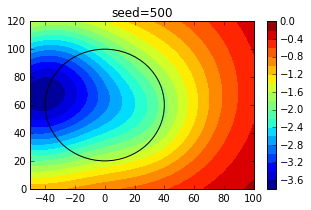

In [28]:
from IPython.html.widgets import interact

x=x_mesh
y=y_mesh

def plot_f(seed):
    np.random.seed(seed)
    F_test_mesh = f_test(x,y,seed)

    fig=plt.figure(figsize=[5,3])
    ax = fig.add_subplot(111)
    cont=ax.contourf(x_mesh,y_mesh,F_test_mesh,20)
    cb = fig.colorbar(cont)
    circ = plt.Circle([0.,H],R,ec='k',fill=False)
    ax.add_patch(circ)
    ax.set_title('seed='+str(seed))

interact(plot_f,seed=(0,1000,1))

In [29]:
rel_error_PCE = []
rel_error_QMC = []
rel_error_QMC2 = []
rel_error_GCL = []

seeds = range(1000)
for seed in seeds:  
    u_eq_MC, x_MC, y_MC = MC_int(f_test,seed)
    u_eq_PCE, x_MC, y_MC, nodes, weights = PCE_int(f_test,seed)
    u_eq_QMC, x_MC, y_MC = QMC_int(f_test,seed)
    u_eq_QMC2, x_MC, y_MC = QMC_int2(f_test,seed)
    u_eq_GCL = gaussN(R,f_r,[seed])

    rel_error_PCE = np.append(rel_error_PCE,100*(u_eq_PCE-u_eq_MC)/u_eq_MC)
    rel_error_QMC = np.append(rel_error_QMC,100*(u_eq_QMC-u_eq_MC)/u_eq_MC)
    rel_error_QMC2 = np.append(rel_error_QMC2,100*(u_eq_QMC2-u_eq_MC)/u_eq_MC)
    rel_error_GCL = np.append(rel_error_GCL,100*(u_eq_GCL-u_eq_MC)/u_eq_MC)

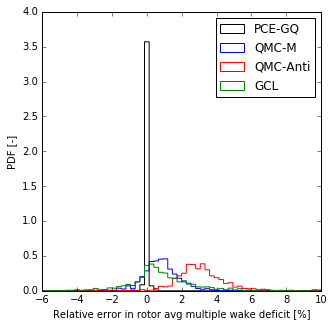

In [35]:
bins = np.linspace(-6,10,61)

fig=plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
ax.hist(rel_error_PCE,bins=bins,normed=True,histtype='step',label='PCE-GQ',color='k')
ax.hist(rel_error_QMC2,bins=bins,normed=True,histtype='step',label='QMC-M',color='b')
ax.hist(rel_error_QMC,bins=bins,normed=True,histtype='step',label='QMC-Anti',color='r')
ax.hist(rel_error_GCL,bins=bins,normed=True,histtype='step',label='GCL',color='g')
ax.set_xlabel('Relative error in rotor avg multiple wake deficit [%]')
ax.set_ylabel('PDF [-]')
plt.legend(loc=1)
fig.savefig('Rotor_avg_int_approx_comparison.pdf')
print

In [33]:
print 'PCE:     ',  np.mean(rel_error_PCE), '\t', np.std(rel_error_PCE)
print 'QMC-M:   ',  np.mean(rel_error_QMC2), '\t', np.std(rel_error_QMC2)
print 'QMC-Anti:',  np.mean(rel_error_QMC), '\t', np.std(rel_error_QMC)
print 'GCL:     ',  np.mean(rel_error_GCL), ' \t', np.std(rel_error_GCL)

PCE:      -0.00440145871899 	0.0715469388069
QMC-M:    0.804744083386 	1.08153825622
QMC-Anti: 3.03208630442 	1.40604671329
GCL:      0.984813935972  	2.30557333339
